# PROYECTO GALLINAS

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image
from collections import defaultdict

In [ ]:
import cv2

## Lectura de datos

In [ ]:
sdir=r"C:/Users/JUAN BUITRAGO/Downloads/archive (5)/Train"
csvpath=r'C:/Users/JUAN BUITRAGO\Downloads/archive (5)/train_data.csv'
df=pd.read_csv(csvpath)
df.columns=['filepaths', 'labels' ]
df['filepaths']=df['filepaths'].apply(lambda x: os.path.join(sdir,x))
print(df.head())
strat=df['labels']

                                           filepaths              labels
0  C:/Users/JUAN BUITRAGO/Downloads/archive (5)/T...          Salmonella
1  C:/Users/JUAN BUITRAGO/Downloads/archive (5)/T...         Coccidiosis
2  C:/Users/JUAN BUITRAGO/Downloads/archive (5)/T...         Coccidiosis
3  C:/Users/JUAN BUITRAGO/Downloads/archive (5)/T...          Salmonella
4  C:/Users/JUAN BUITRAGO/Downloads/archive (5)/T...  New Castle Disease


## Analisis exploratorio de datos

Al momento de leer los datos comenzamos con un grafico de barras para ver la distribucion de la variable respuesta.

In [ ]:
classes=list(df['labels'].unique())
class_count = len(classes)
groups=df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
for label in df['labels'].unique():
      group=groups.get_group(label)      
      print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

            CLASS               IMAGE COUNT 
          Salmonella               2625     
         Coccidiosis               2476     
      New Castle Disease            562     
           Healthy                 2404     


c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


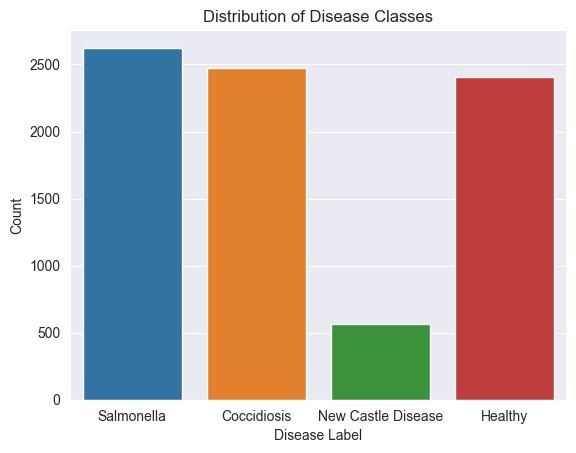

In [ ]:
sns.countplot(data=df, x="labels")
plt.xlabel("Disease Label")
plt.ylabel("Count")
plt.title("Distribution of Disease Classes")
plt.show()

Notamos un claro desbalance en la variable respueta, especialmente de la enfermadad "New Castle Disease"

A continuacion mostraremos una muestra de 4 imagenes por enfermedad

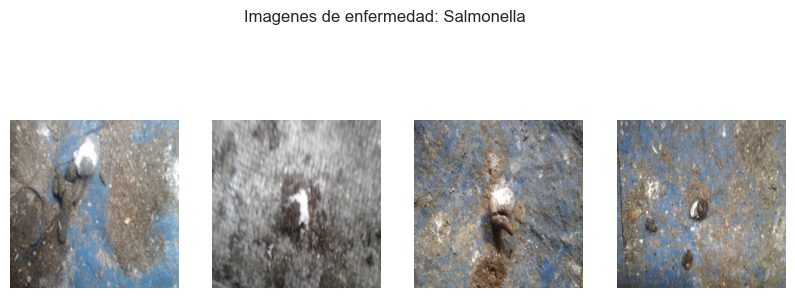

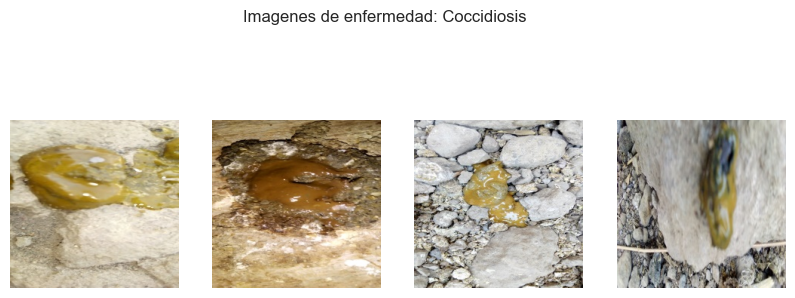

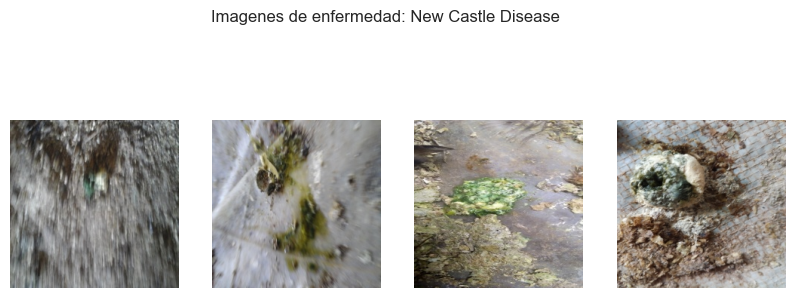

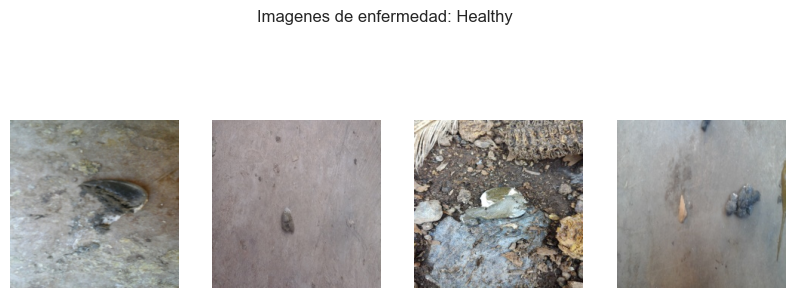

In [ ]:
num_samples = 4

for disease_label in df["labels"].unique():
    class_images = df.loc[df["labels"] == disease_label, "filepaths"].sample(
        num_samples
    )
    plt.figure(figsize=(10, 4))

    for i, image_file_name in enumerate(class_images):
        image_path = os.path.join(sdir, image_file_name)
        image = Image.open(image_path)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.axis("off")
    plt.suptitle(f"Imagenes de enfermedad: {disease_label}")
    plt.show()

Podemos observar que hay una cantidad alta de ruido en las fotos, desde fotos borrosas a objetos en el fondo de algunas. Esto puede influir en los resultados del modelo.

### Analisis del tamaño y dimension de las imagenes

In [ ]:
img_prop = defaultdict(list)

for i, img_path in enumerate(df['filepaths']):
    # Abrir la imagen con PIL
    img = Image.open(img_path)
    
    # Obtener las propiedades de la imagen
    img_prop['image_id'].append(img_path[-12:-4])
    img_prop['width'].append(img.width)
    img_prop['height'].append(img.height)
    img_prop['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
    img_prop['path'].append(img_path)

# Crear DataFrame con las propiedades de las imágenes
image_data = pd.DataFrame(img_prop)

# Calcular el aspect ratio de las imágenes
image_data['img_aspect_ratio'] = image_data['width'] / image_data['height']

image_data.sort_values(by='image_id', inplace=True)
image_data.reset_index(inplace=True, drop=True)
image_data.head()

,image_id,width,height,size,path,img_aspect_ratio
0,\cocci.0,224,224,0.03,C:/Users/JUAN BUITRAGO/Downloads/archive (5)/T...,1.0
1,\cocci.1,224,224,0.04,C:/Users/JUAN BUITRAGO/Downloads/archive (5)/T...,1.0
2,\cocci.2,224,224,0.02,C:/Users/JUAN BUITRAGO/Downloads/archive (5)/T...,1.0
3,\cocci.3,224,224,0.03,C:/Users/JUAN BUITRAGO/Downloads/archive (5)/T...,1.0
4,\cocci.4,224,224,0.03,C:/Users/JUAN BUITRAGO/Downloads/archive (5)/T...,1.0


c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

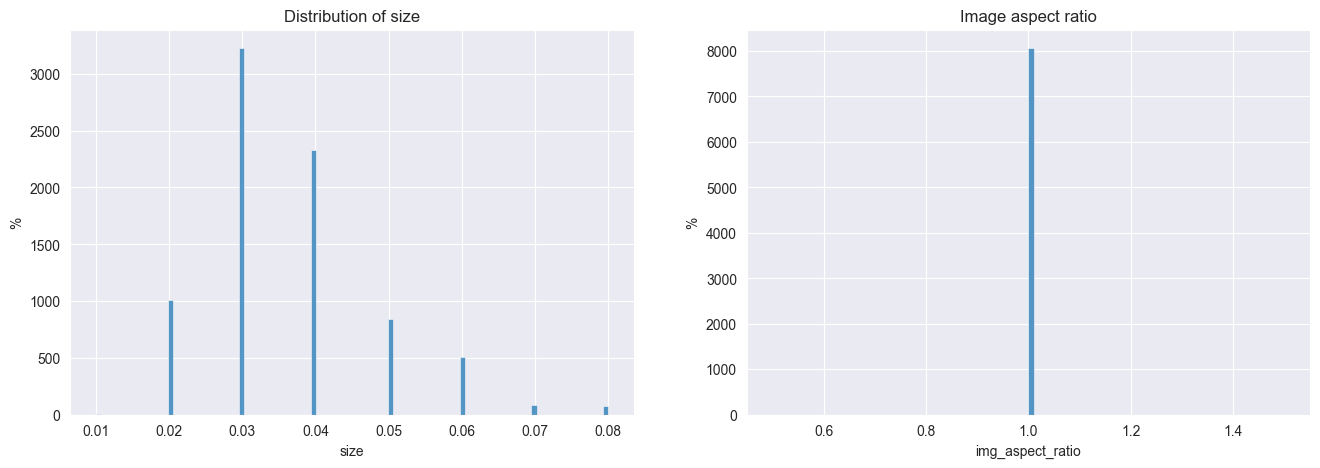

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.histplot(x='size', data = image_data, bins=100, ax=ax[0])
ax[0].set_title("Distribution of size"), ax[0].set_ylabel("%")
sns.histplot(x='img_aspect_ratio', data = image_data, bins=100, ax=ax[1])
ax[1].set_title("Image aspect ratio"), ax[1].set_ylabel("%")
plt.show()

Observamos que todas las imagenes tienen el mismo ratio, y todas tienen un peso similiar. Esto nos da indicio de un proceso de toma de datos de alta calidad, o de un preprocesamiento previo.

### Analisis de los canales de color

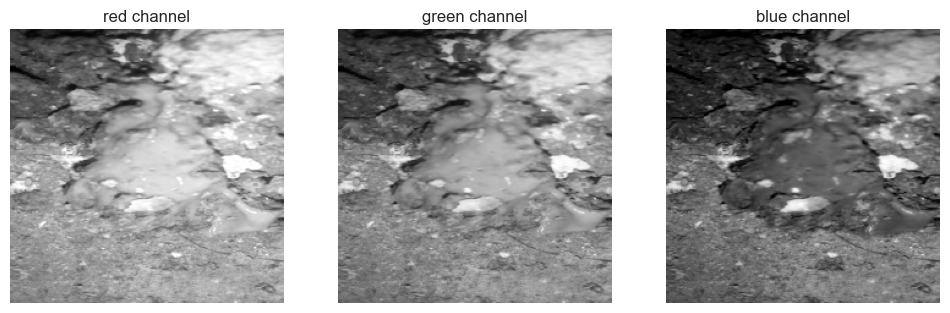

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,12))
colors = ['red', 'green', 'blue']
for i, ax in enumerate(axes):
    img = imread(df['filepaths'][10])[:, :, :3]
    ax.imshow(img[:,:,i], cmap='gray')
    ax.set_title(colors[i]+' channel'), ax.axis('off')
plt.show()

Observamos una ligera diferencia en las imagenes en cada canal, esto nos confirma que debemos trabajar las imagenes con sus colores, y no trabajar en escala de grises.

c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

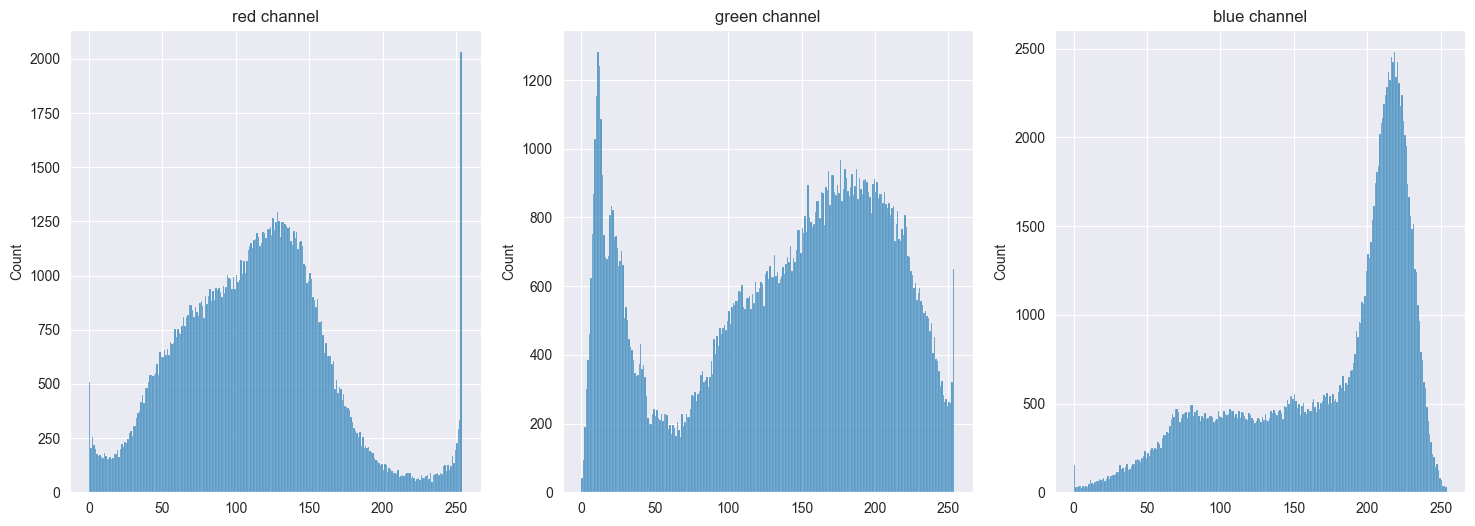

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(18,6))
for i, ax in enumerate(axes):
    img = imread(df['filepaths'][i])[:, :, :3]
    dfcolor = img.ravel()
    sns.histplot(dfcolor, bins=np.arange(0,255), ax=ax)
    ax.set_title(colors[i]+' channel')
plt.show()

Así se distribuye el valor de cada canal de color para todas las imagenes.

c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

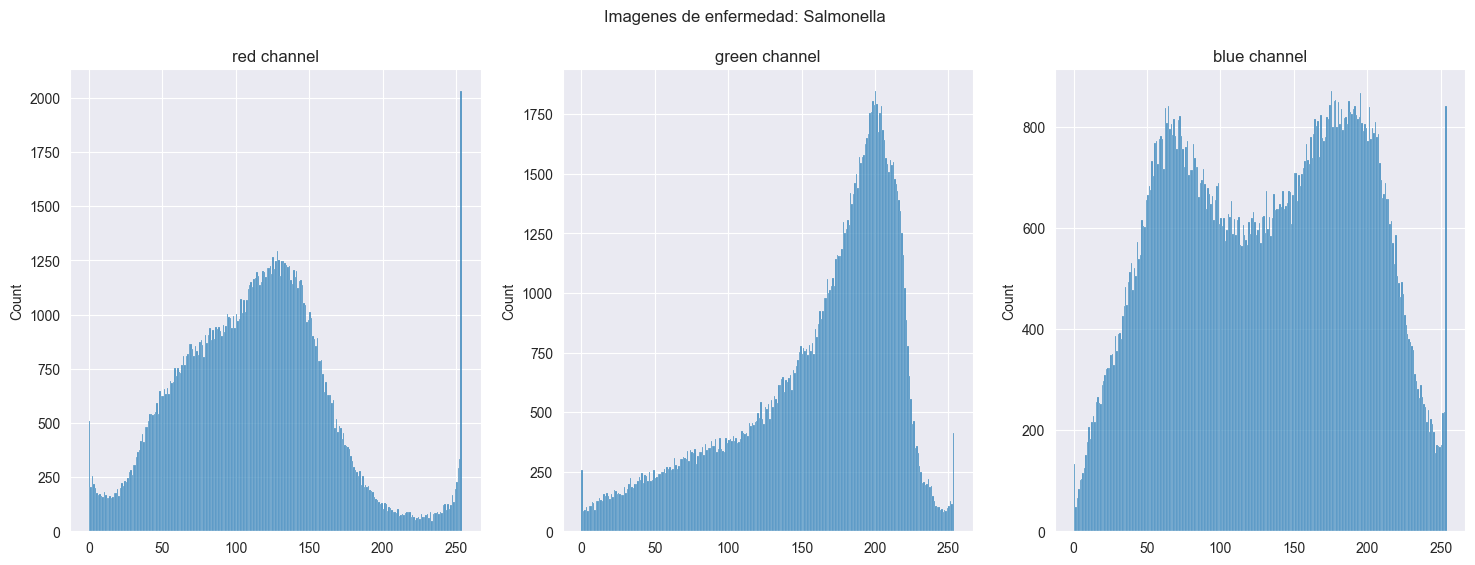

c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

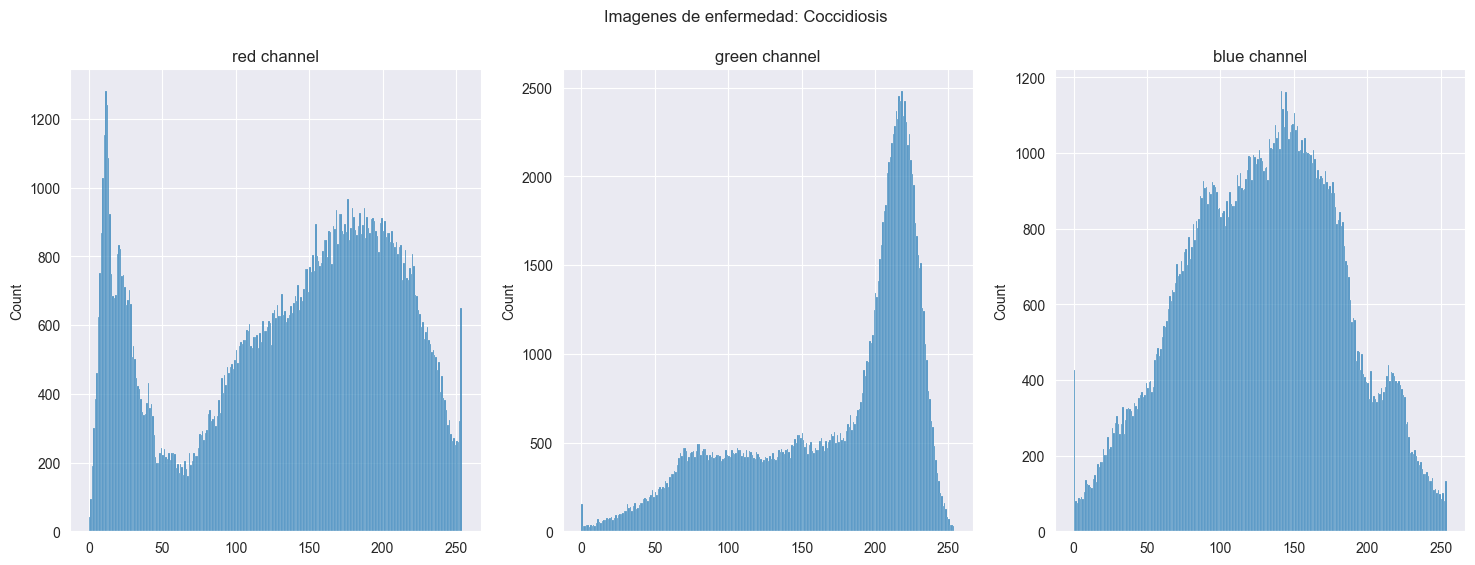

c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

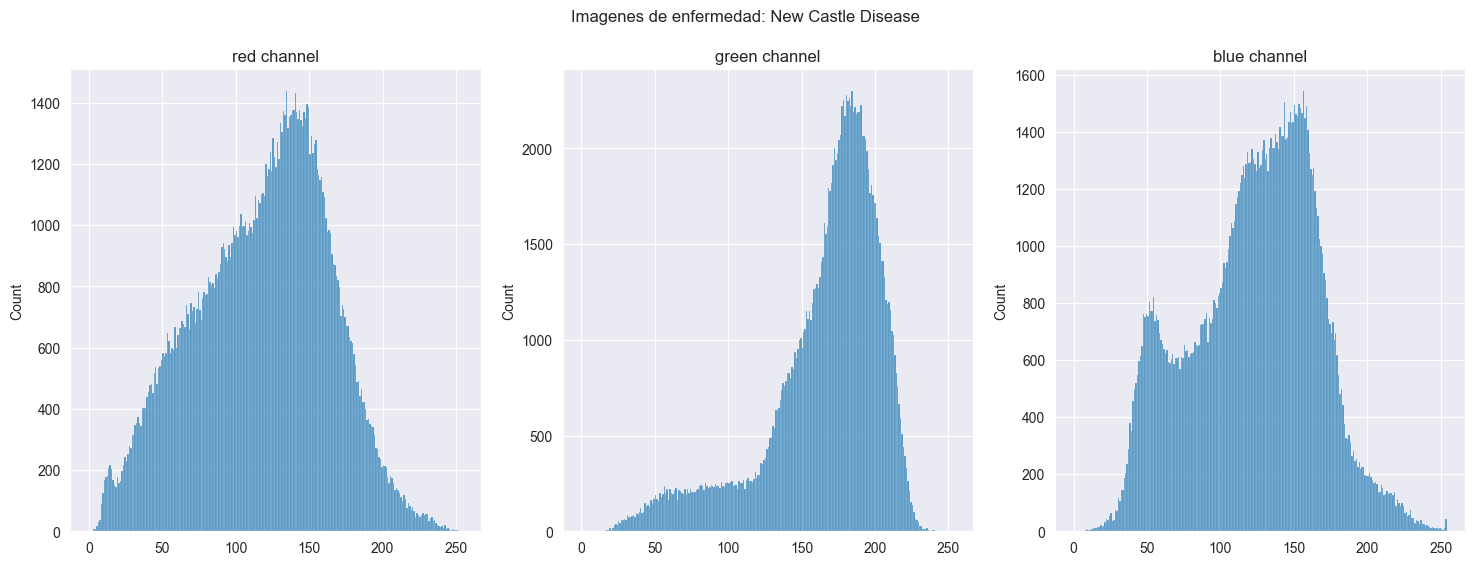

c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\miniconda\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

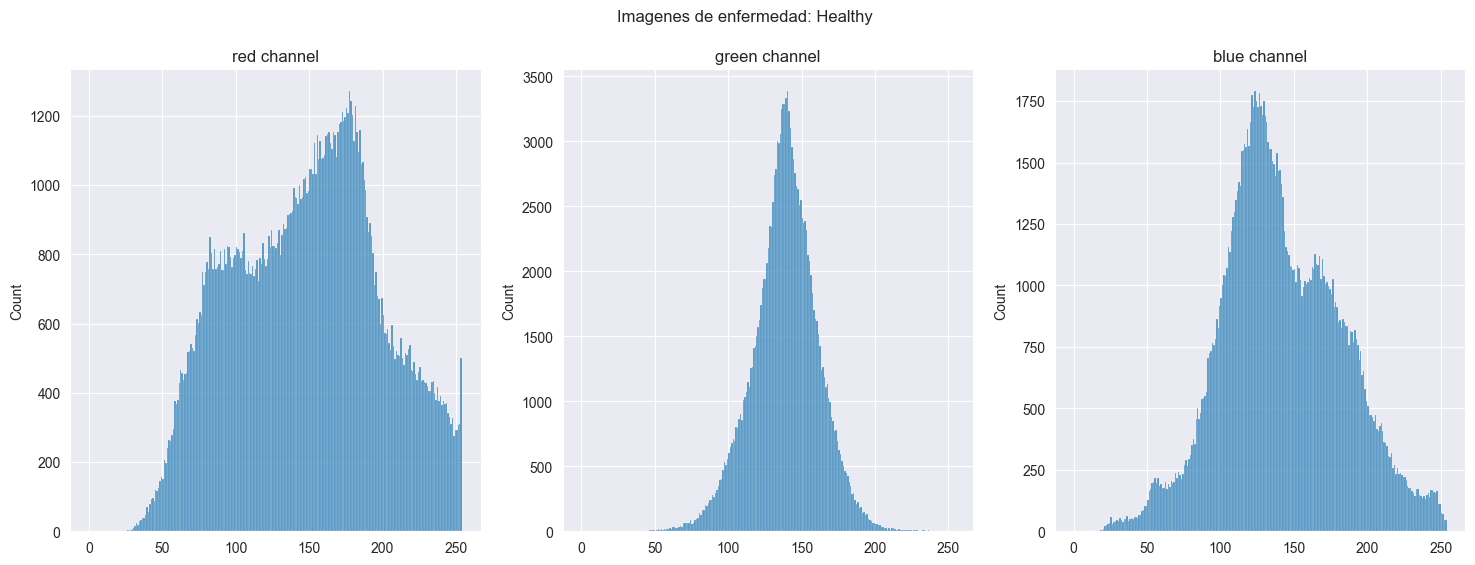

In [ ]:
for disease_label in df["labels"].unique():
    class_images = df[df["labels"] == disease_label]
    class_images.reset_index(inplace=True, drop=True)

    fig, axes = plt.subplots(1,3, figsize=(18,6))
    for i, ax in enumerate(axes):
        img = imread(class_images['filepaths'][i])[:, :, :3]
        dfcolor = img.ravel()
        sns.histplot(dfcolor, bins=np.arange(0,255), ax=ax)
        ax.set_title(colors[i]+' channel')
 
    plt.suptitle(f"Imagenes de enfermedad: {disease_label}")
    plt.show()

Y así se distribuye para cada clase, podemos observar una leve diferencia, dando a entender tambien que debemos trabajar con los 3 canales.

In [ ]:
# Crear DataFrame con una imagen de cada enfermedad
unique_labels = df['labels'].unique()
one_image_per_label = []
for label in unique_labels:
    group = df[df['labels'] == label]
    one_image_per_label.append(group.iloc[100])

one_image_df = pd.DataFrame(one_image_per_label)
one_image_df

,filepaths,labels
342,C:/Users/JUAN BUITRAGO/Downloads/archive (5)/T...,Salmonella
298,C:/Users/JUAN BUITRAGO/Downloads/archive (5)/T...,Coccidiosis
1646,C:/Users/JUAN BUITRAGO/Downloads/archive (5)/T...,New Castle Disease
339,C:/Users/JUAN BUITRAGO/Downloads/archive (5)/T...,Healthy


### Filtros variados

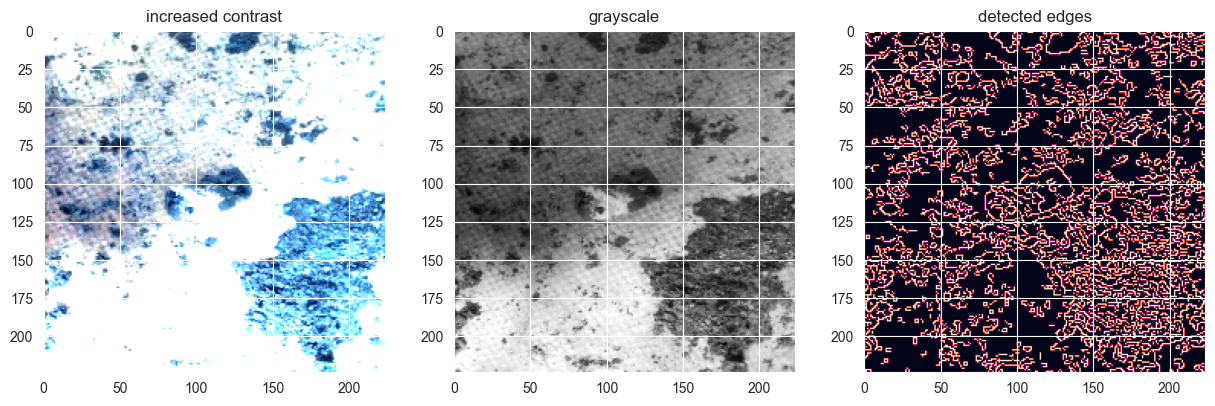

In [ ]:
filepaths_column = one_image_df["filepaths"]
img_path_Coccidiosis= filepaths_column.iloc[0] 

img = cv2.imread(img_path_Coccidiosis, cv2.IMREAD_COLOR)
image_resized = cv2.resize(img, (0,0), fx=1, fy=1)

contrast_img = cv2.addWeighted(image_resized, 2.5, np.zeros(image_resized.shape, image_resized.dtype), 0, 0)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

min_intensity_grad, max_intensity_grad = 100, 200
edge_img = cv2.Canny(image_resized, min_intensity_grad, max_intensity_grad)

fig, ax = plt.subplots(1,3, figsize=(15,20))
ax[0].imshow(contrast_img); ax[0].set_title('increased contrast')
ax[1].imshow(img_gray, cmap='gray', vmin = 0, vmax = 255); ax[1].set_title('grayscale')
ax[2].imshow(edge_img); ax[2].set_title('detected edges')
plt.show()

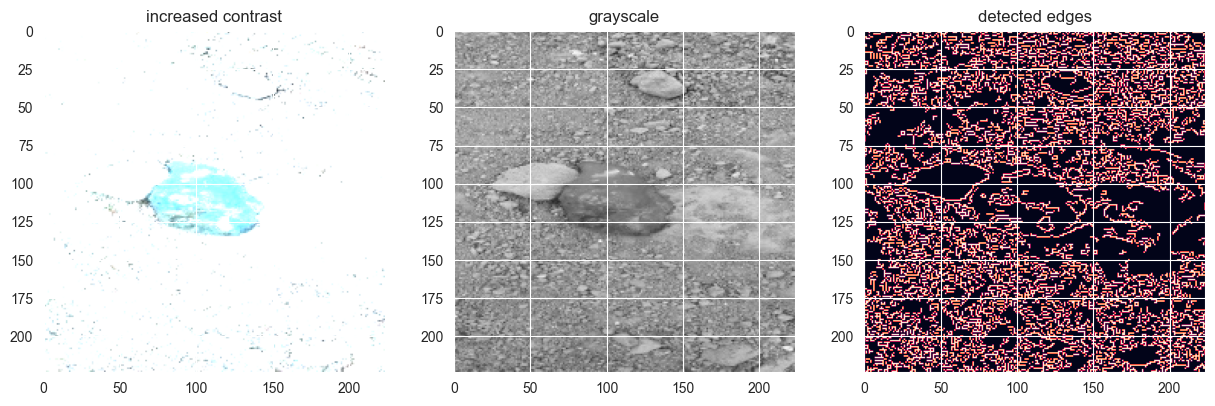

In [ ]:
filepaths_column = one_image_df["filepaths"]
img_path_Salmonella= filepaths_column.iloc[1] 

img = cv2.imread(img_path_Salmonella, cv2.IMREAD_COLOR)
image_resized = cv2.resize(img, (0,0), fx=1, fy=1)

contrast_img = cv2.addWeighted(image_resized, 2.5, np.zeros(image_resized.shape, image_resized.dtype), 0, 0)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

min_intensity_grad, max_intensity_grad = 100, 200
edge_img = cv2.Canny(image_resized, min_intensity_grad, max_intensity_grad)

fig, ax = plt.subplots(1,3, figsize=(15,20))
ax[0].imshow(contrast_img); ax[0].set_title('increased contrast')
ax[1].imshow(img_gray, cmap='gray', vmin = 0, vmax = 255); ax[1].set_title('grayscale')
ax[2].imshow(edge_img); ax[2].set_title('detected edges')
plt.show()

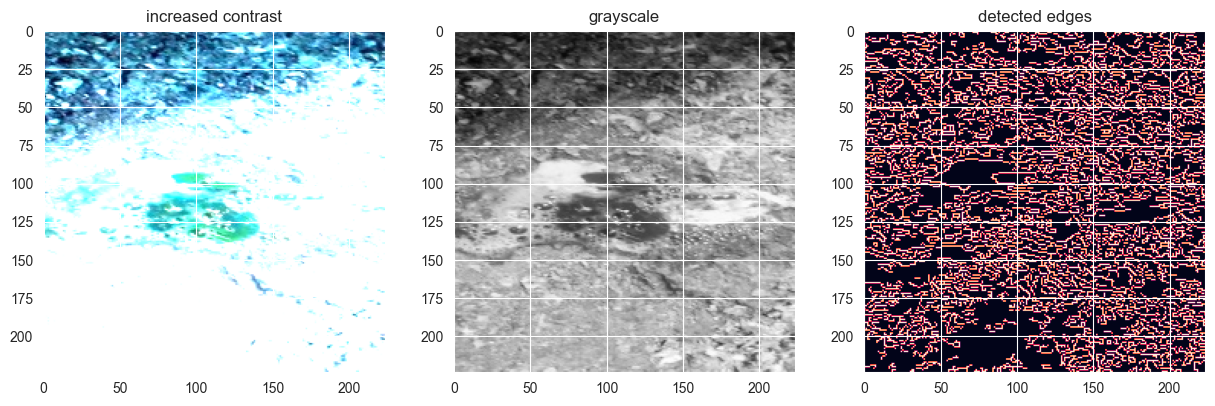

In [ ]:
filepaths_column = one_image_df["filepaths"]
img_path_Healthy= filepaths_column.iloc[2] 

img = cv2.imread(img_path_Healthy, cv2.IMREAD_COLOR)
image_resized = cv2.resize(img, (0,0), fx=1, fy=1)

contrast_img = cv2.addWeighted(image_resized, 2.5, np.zeros(image_resized.shape, image_resized.dtype), 0, 0)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

min_intensity_grad, max_intensity_grad = 100, 200
edge_img = cv2.Canny(image_resized, min_intensity_grad, max_intensity_grad)

fig, ax = plt.subplots(1,3, figsize=(15,20))
ax[0].imshow(contrast_img); ax[0].set_title('increased contrast')
ax[1].imshow(img_gray, cmap='gray', vmin = 0, vmax = 255); ax[1].set_title('grayscale')
ax[2].imshow(edge_img); ax[2].set_title('detected edges')
plt.show()

esto nos sirve para ver unas imagenes de ejemplo de las diferentes clases en escala en 3 diferentes formatos. nos puede ayudar a ver si se detectan ciertos patrones. 